In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

In [7]:
file_path = 'train.csv'
df  = pd.read_csv(file_path)
spaceship_data = df
print(len(spaceship_data))
spaceship_data.head()

8693


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Data wrangling
1. Check missing values

In [8]:
missing_values = spaceship_data.isnull().sum()
missing_values[missing_values > 0]

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

2. Fill in/ drop missing values

In [9]:
spaceship_data = spaceship_data.dropna(subset=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination'])

# Fill missing categorical values with the mode
for column in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']:
    spaceship_data[column].fillna(spaceship_data[column].mode()[0], inplace=True)

# Fill missing numerical values with the median
for column in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    spaceship_data[column].fillna(spaceship_data[column].median(), inplace=True)

missing_values_after = spaceship_data.isnull().sum()
missing_values_after[missing_values_after > 0]


C:\Users\shami\AppData\Local\Temp\ipykernel_4536\2796621290.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spaceship_data[column].fillna(spaceship_data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_4536\2796621290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spaceship_data[column].fillna(spaceship_dat

Series([], dtype: int64)

3. Feature engineering (improves random forrest model from 78% to 80%)

In [10]:
# Splitting the 'Cabin' into  'Deck', 'CabinNumber', and 'Side'
spaceship_data[['Deck', 'CabinNumber', 'Side']] = spaceship_data['Cabin'].astype(str).str.split('/', expand=True)
spaceship_data['CabinNumber'] = pd.to_numeric(spaceship_data['CabinNumber'], errors='coerce')
spaceship_data = spaceship_data.drop(columns=['Cabin'])

# 'TotalSpend' feature  (RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck)
spaceship_data['TotalSpend'] = (
    spaceship_data['RoomService'] +
    spaceship_data['FoodCourt'] +
    spaceship_data['ShoppingMall'] +
    spaceship_data['Spa'] +
    spaceship_data['VRDeck']
)

# Create age groups
bins = [0, 12, 18, 35, 60, 100]
labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
spaceship_data['AgeGroup'] = pd.cut(spaceship_data['Age'], bins=bins, labels=labels)


C:\Users\shami\AppData\Local\Temp\ipykernel_4536\337104198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spaceship_data[['Deck', 'CabinNumber', 'Side']] = spaceship_data['Cabin'].astype(str).str.split('/', expand=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_4536\337104198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spaceship_data[['Deck', 'CabinNumber', 'Side']] = spaceship_data['Cabin'].astype(str).str.split('/', expand=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_4536\337104198.py:

4. Check target variable balance

In [11]:
# Check the balance of the target variable 'Transported'
target_balance = spaceship_data['Transported'].value_counts(normalize=True)
target_balance


Transported
True     0.503914
False    0.496086
Name: proportion, dtype: float64

3. Encode categorical variables

In [12]:
label_encoder = LabelEncoder()
for column in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Deck', 'Side', 'AgeGroup']:
    spaceship_data[column] = label_encoder.fit_transform(spaceship_data[column])
spaceship_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNumber,Side,TotalSpend,AgeGroup
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,4794,False,1,0,0,0.0,0
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,4109,True,5,0,1,736.0,4
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,412,False,0,0,1,10383.0,0
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,6503,False,0,0,1,5176.0,4
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,7583,True,5,1,1,1091.0,3


4. Split train and test data

In [13]:
# Split the dataset into features and target
X = spaceship_data.drop(columns=['PassengerId', 'Transported'])
y = spaceship_data['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models 
1. Random forrest 

In [14]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
best_params, accuracy_best, report_best

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
262 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

({'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 200},
 0.8005050505050505,
 '              precision    recall  f1-score   support\n\n       False       0.80      0.80      0.80       794\n        True       0.80      0.80      0.80       790\n\n    accuracy                           0.80      1584\n   macro avg       0.80      0.80      0.80      1584\nweighted avg       0.80      0.80      0.80      1584\n')

# Model improvement
1. Consider PCA
    Variable are not highly correlated hence not using PCA 

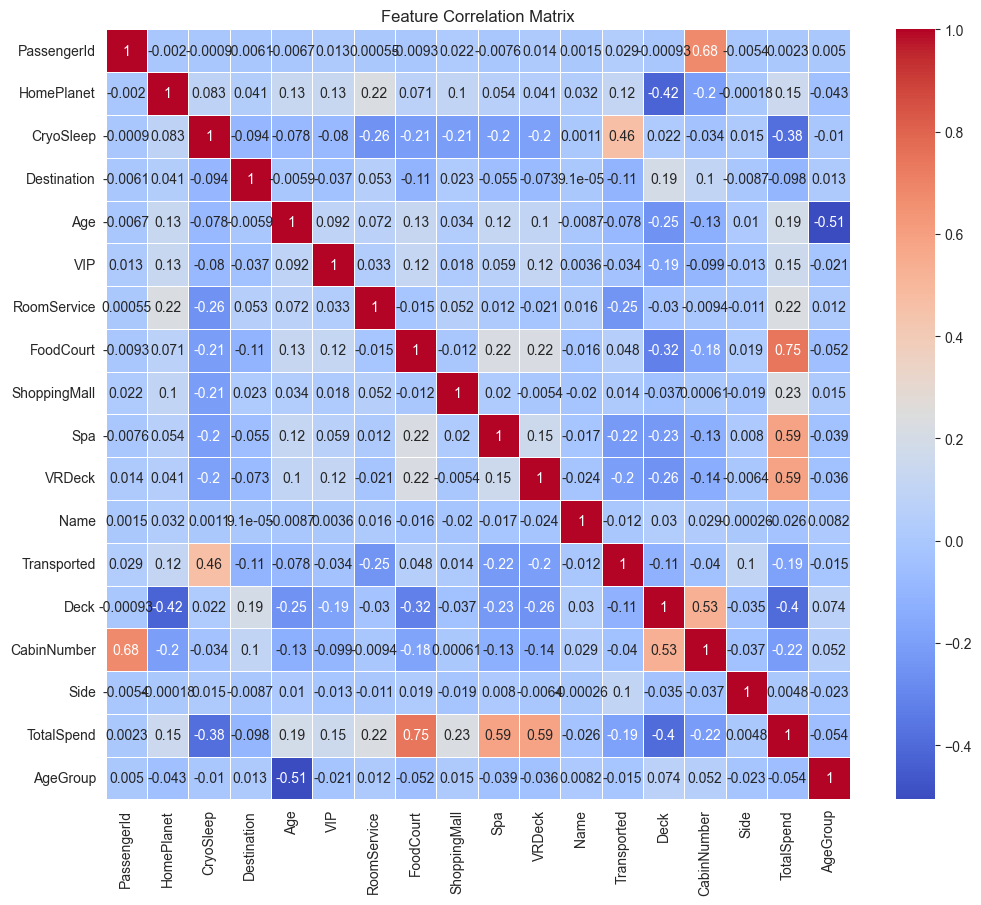

,Feature 1,Feature 2,Correlation


In [15]:
# Calculate the correlation matrix
correlation_matrix = spaceship_data.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white')
plt.title('Feature Correlation Matrix')
plt.show()

# Check for high correlation (above 0.8)
high_correlation_pairs = correlation_matrix[(correlation_matrix > 0.8) & (correlation_matrix != 1.0)].stack().reset_index()
high_correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs

2. Ensemble methods (Stacking), improved from 80% to 80.36%

In [16]:
# 1. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

# 2. XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

# 3. Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
report_stack = classification_report(y_test, y_pred_stack)

# Results
print("Gradient Boosting Accuracy:", accuracy_gb)
print(report_gb)
print("XGBoost Accuracy:", accuracy_xgb)
print(report_xgb)
print("Stacking Classifier Accuracy:", accuracy_stack)
print(report_stack)

C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Gradient Boosting Accuracy: 0.797979797979798
              precision    recall  f1-score   support

       False       0.81      0.78      0.79       794
        True       0.79      0.82      0.80       790

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584

XGBoost Accuracy: 0.7954545454545454
              precision    recall  f1-score   support

       False       0.81      0.78      0.79       794
        True       0.78      0.81      0.80       790

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584

Stacking Classifier Accuracy: 0.8036616161616161
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       794
        True       0.80      0.81      0.81       790

    accuracy                           0.80      1

3. XGBoost model using GridSearchCV for hyperparameter tuning (improved from 0.795 to 0.797)

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_xgb

Fitting 3 folds for each of 54 candidates, totalling 162 fits


0.7973484848484849

4. Gradient boost with grid search
    ###### improve from 79.798 to 80.618

In [18]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_gb_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_gb = best_gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb}")

# Classification report
report_gb = classification_report(y_test, y_pred_gb)
report_gb

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Accuracy: 0.8061868686868687


'              precision    recall  f1-score   support\n\n       False       0.82      0.79      0.80       794\n        True       0.80      0.82      0.81       790\n\n    accuracy                           0.81      1584\n   macro avg       0.81      0.81      0.81      1584\nweighted avg       0.81      0.81      0.81      1584\n'

5. Neural networks
    ###### Accuracy1 :- 77.904
    ###### Accuracy2 :- 80.03

In [19]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Add Batch Normalization for faster convergence
model.add(Dropout(0.4))  # Increased dropout rate to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate for more fine-tuned updates
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stopping], verbose=2)

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
159/159 - 4s - 24ms/step - accuracy: 0.6719 - loss: 0.6434 - val_accuracy: 0.7713 - val_loss: 0.5403
Epoch 2/200
159/159 - 0s - 3ms/step - accuracy: 0.7307 - loss: 0.5702 - val_accuracy: 0.7800 - val_loss: 0.5212
Epoch 3/200
159/159 - 0s - 3ms/step - accuracy: 0.7516 - loss: 0.5427 - val_accuracy: 0.7737 - val_loss: 0.5169
Epoch 4/200
159/159 - 0s - 3ms/step - accuracy: 0.7543 - loss: 0.5408 - val_accuracy: 0.7752 - val_loss: 0.4999
Epoch 5/200
159/159 - 0s - 3ms/step - accuracy: 0.7678 - loss: 0.5198 - val_accuracy: 0.7744 - val_loss: 0.5000
Epoch 6/200
159/159 - 0s - 3ms/step - accuracy: 0.7640 - loss: 0.5188 - val_accuracy: 0.7863 - val_loss: 0.4949
Epoch 7/200
159/159 - 0s - 3ms/step - accuracy: 0.7703 - loss: 0.5195 - val_accuracy: 0.7823 - val_loss: 0.4961
Epoch 8/200
159/159 - 0s - 3ms/step - accuracy: 0.7731 - loss: 0.5098 - val_accuracy: 0.7815 - val_loss: 0.4991
Epoch 9/200
159/159 - 0s - 3ms/step - accuracy: 0.7739 - loss: 0.5077 - val_accuracy: 0.7831 - val_loss

In [26]:
pip install pandoc 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/128.0 kB ? eta -:--:--
   -------------------------------------- - 122.9/128.0 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 128.0/128.0 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/49.6 kB ? eta -:--:--
   ---------------------------------------- 49.6/49.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34821 sha256=5a6609aed6d06776db20e8d1ad5cbb009c3f8a3b633932a0aa2c21c1eeb5ef17
  Stored in directory: c:\users\shami\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built pandoc



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\shami\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
